In [209]:
import sklearn
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from joblib import dump

In [233]:
data = pd.read_csv('stats_dataset.csv')
data_copy = data.copy()
data.pop('home_name')
data.pop('away_name')

0                 Piast Gliwice
1                  GKS Katowice
2                Pogoń Szczecin
3                 Korona Kielce
4                   Stal Mielec
5                 Śląsk Wrocław
6                  Motor Lublin
7                   Widzew Łódź
8                      Cracovia
9           Puszcza Niepołomice
10                  Lech Poznań
11               Zagłębie Lubin
12               Legia Warszawa
13                Górnik Zabrze
14            Raków Częstochowa
15                Lechia Gdańsk
16        Jagiellonia Białystok
17               Radomiak Radom
18               Legia Warszawa
19                 Motor Lublin
20                  Stal Mielec
21                  Lech Poznań
22                     Cracovia
23                Korona Kielce
24        Jagiellonia Białystok
25                  Widzew Łódź
26               Pogoń Szczecin
27                Śląsk Wrocław
28                Piast Gliwice
29                 GKS Katowice
30                Górnik Zabrze
31      

In [234]:
data = data[data['result'].notna()]

In [235]:
target = data.pop('result').astype('int8')
target.info()

<class 'pandas.core.series.Series'>
RangeIndex: 18560 entries, 0 to 18559
Series name: result
Non-Null Count  Dtype
--------------  -----
18560 non-null  int8 
dtypes: int8(1)
memory usage: 18.3 KB


In [236]:
def draw_confussion_matrix(y_test, y_pred, model_classes):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_classes)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

def use_cross_validation(model, x, y, n_splits, n_jobs=5):
    scores = cross_val_score(estimator=model, X=x, y=y, cv=n_splits, n_jobs=n_splits)
    print('Mean score CV:', scores.mean())
    print('All scores CV:', scores)
    return scores

In [237]:
cols = data.select_dtypes(include='number').columns
pd.set_option('display.max_rows', None)

In [247]:
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, stratify=target)

In [248]:
x_train = x_train.drop(['fortuna_home', 'fortuna_draw', 'fortuna_away', 'superbet_home', 'superbet_draw', 'superbet_away'], axis=1)
x_test = x_test.drop(['fortuna_home', 'fortuna_draw', 'fortuna_away', 'superbet_home', 'superbet_draw', 'superbet_away'], axis=1)

In [249]:
print('x_train shape: ', x_train.shape)
print('y_train shape: ', y_train.shape)
print('x_test shape: ', x_test.shape)
print('y_test shape: ', y_test.shape)

print('train values:\n', y_train.value_counts(dropna=False))
print('test values:\n', y_test.value_counts(dropna=False))

x_test.pop('match_date')
x_train.pop('match_date')
print(x_train.select_dtypes(include=['object', 'category']).columns.tolist())

x_train shape:  (14848, 290)
y_train shape:  (14848,)
x_test shape:  (3712, 290)
y_test shape:  (3712,)
train values:
 result
1    6508
2    4526
0    3814
Name: count, dtype: int64
test values:
 result
1    1627
2    1132
0     953
Name: count, dtype: int64
[]


In [250]:
from  sklearn.preprocessing import StandardScaler, MinMaxScaler


scaler = StandardScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train.values), index=x_train.index, columns=x_train.columns)
x_test = pd.DataFrame(scaler.transform(x_test.values), index=x_test.index, columns=x_test.columns)

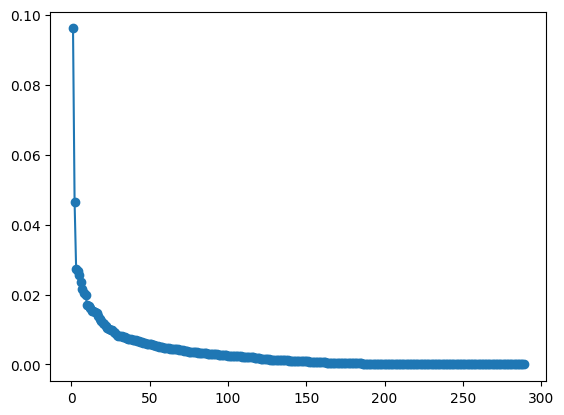

In [251]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


pca = PCA()
pca.fit(x_train)
variances = pca.explained_variance_ratio_
plt.plot(np.arange(1, len(variances)+1), variances, marker='o')

In [252]:
pca = PCA(n_components=25)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)

In [253]:
model = RandomForestClassifier(n_estimators=300, criterion='entropy',
        max_depth=5, min_samples_split=20, min_samples_leaf=10, max_features='sqrt',)

scores = use_cross_validation(model, x_train, y_train, 5, n_jobs=-1)

model.fit(x_train, y_train)

train_score = model.score(x_train, y_train)
test_score = model.score(x_test, y_test)

print('Score on training data: ', train_score)
print('Score on test data: ', test_score)

y_pred = model.predict(x_test)

print(np.bincount(y_pred))
print('classification report:\n', classification_report(y_test, y_pred, zero_division=0,))

Mean score CV: 0.49427534580111204
All scores CV: [0.5040404  0.49191919 0.48653199 0.48703267 0.50185248]
Score on training data:  0.5144127155172413
Score on test data:  0.49030172413793105
[   0 2873  839]
classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       953
           1       0.49      0.87      0.63      1627
           2       0.48      0.36      0.41      1132

    accuracy                           0.49      3712
   macro avg       0.32      0.41      0.35      3712
weighted avg       0.36      0.49      0.40      3712



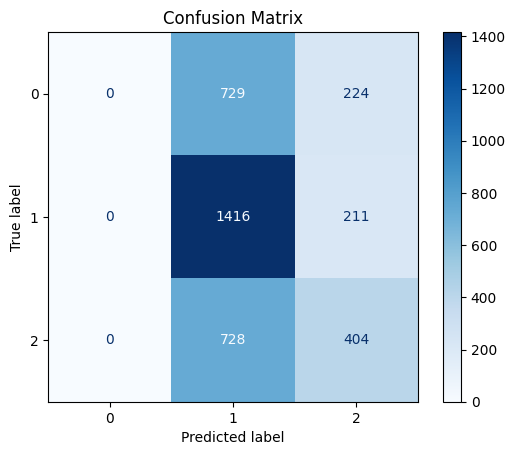

In [254]:
draw_confussion_matrix(y_test, y_pred, model.classes_)
# dump(model, f'rfc_{test_score}_acc.joblib')

In [272]:
from sklearn.linear_model import LogisticRegression


lr = LogisticRegression()

scores = use_cross_validation(lr, x_train, y_train, n_splits=5)

lr.fit(x_train, y_train)

train_score = lr.score(x_train, y_train)
test_score = lr.score(x_test, y_test)

print('Score on training data: ', train_score)
print('Score on test data: ', test_score)

y_pred = lr.predict(x_test)

print(np.bincount(y_pred))
print('classification report:\n', classification_report(y_test, y_pred, zero_division=0))

Mean score CV: 0.49427518703369155
All scores CV: [0.503367   0.49023569 0.49124579 0.4853486  0.50117885]
Score on training data:  0.4978448275862069
Score on test data:  0.49191810344827586
[  15 2530 1167]
classification report:
               precision    recall  f1-score   support

           0       0.20      0.00      0.01       953
           1       0.51      0.80      0.62      1627
           2       0.45      0.47      0.46      1132

    accuracy                           0.49      3712
   macro avg       0.39      0.42      0.36      3712
weighted avg       0.41      0.49      0.41      3712



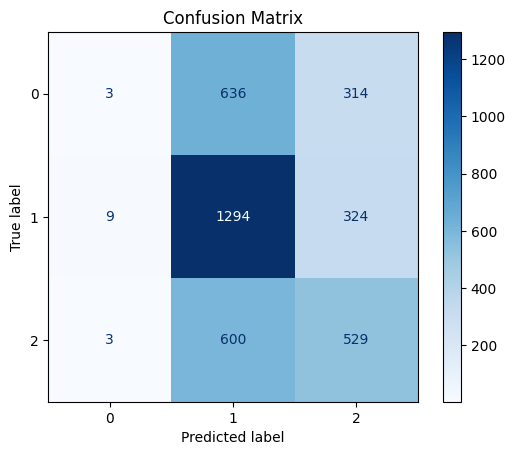

In [273]:
draw_confussion_matrix(y_test, y_pred, lr.classes_)
# dump(model, f'lr_{test_score}_acc.joblib')

In [300]:
from xgboost import XGBClassifier

xgb = XGBClassifier(eval_metric='auc', n_estimators=500, learning_rate=0.01, max_depth=2, alpha=.2, gamma=2.)

scores = use_cross_validation(xgb, x_train, y_train, 5, -1)

xgb.fit(x_train, y_train)

train_score = xgb.score(x_train, y_train)
test_score = xgb.score(x_test, y_test)

print('Score on training data: ', train_score)
print('Score on test data: ', test_score)

y_pred = xgb.predict(x_test)

print(np.bincount(y_pred))
print('classification report:\n', classification_report(y_test, y_pred, zero_division=0))

Mean score CV: 0.4963635002772759
All scores CV: [0.5040404  0.49393939 0.48585859 0.49376895 0.50421017]
Score on training data:  0.4995959051724138
Score on test data:  0.49407327586206895
[   1 2688 1023]
classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       953
           1       0.50      0.83      0.63      1627
           2       0.47      0.43      0.45      1132

    accuracy                           0.49      3712
   macro avg       0.32      0.42      0.36      3712
weighted avg       0.36      0.49      0.41      3712



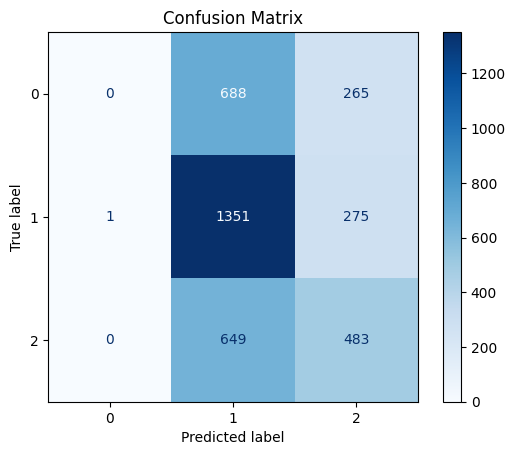

In [301]:
draw_confussion_matrix(y_test, y_pred, xgb.classes_)
# dump(xgb, f'xgb_{test_score}_acc.joblib')

In [319]:
from sklearn.neighbors  import KNeighborsClassifier

kn = KNeighborsClassifier(n_neighbors=25, weights='uniform')

scores = use_cross_validation(kn, x_train, y_train, n_splits=5)

kn.fit(x_train, y_train)

train_score = kn.score(x_train, y_train)
test_score = kn.score(x_test, y_test)

print('Score on training data: ', train_score)
print('Score on test data: ', test_score)

y_pred = kn.predict(x_test)

print('classification report:\n', classification_report(y_test, y_pred))

Mean score CV: 0.4669313999997732
All scores CV: [0.48653199 0.46565657 0.45117845 0.47187605 0.45941394]
Score on training data:  0.5238415948275862
Score on test data:  0.46875
classification report:
               precision    recall  f1-score   support

           0       0.30      0.14      0.19       953
           1       0.51      0.73      0.60      1627
           2       0.45      0.37      0.41      1132

    accuracy                           0.47      3712
   macro avg       0.42      0.41      0.40      3712
weighted avg       0.44      0.47      0.44      3712



In [326]:
from sklearn.svm import SVC


svc = SVC(kernel='rbf')

scores = use_cross_validation(svc, x_train, y_train, 5, -1)

svc.fit(x_train, y_train)

train_score = svc.score(x_train, y_train)
test_score = svc.score(x_test, y_test)

print('Score on training data: ', train_score)
print('Score on test data: ', test_score)

y_pred = svc.predict(x_test)

print(np.bincount(y_pred))
print('classification report:\n', classification_report(y_test, y_pred))

Mean score CV: 0.49272677374395124
All scores CV: [0.4983165  0.48686869 0.48585859 0.49545301 0.49713708]
Score on training data:  0.5583243534482759
Score on test data:  0.48841594827586204
[  39 2678  995]
classification report:
               precision    recall  f1-score   support

           0       0.28      0.01      0.02       953
           1       0.50      0.82      0.62      1627
           2       0.46      0.41      0.43      1132

    accuracy                           0.49      3712
   macro avg       0.42      0.41      0.36      3712
weighted avg       0.43      0.49      0.41      3712



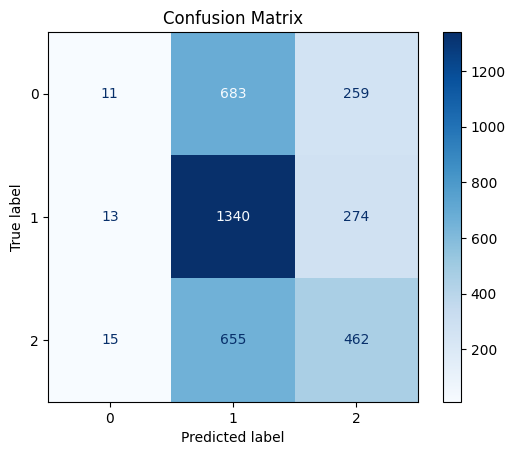

In [327]:
draw_confussion_matrix(y_test, y_pred, svc.classes_)
# dump(svc, f'svc_{test_score}_acc.joblib')

In [337]:
from catboost import CatBoostClassifier


cbc = CatBoostClassifier(iterations=1000, learning_rate=0.001, min_data_in_leaf=15, verbose=0)

scores = use_cross_validation(cbc, x_train, y_train, 5, n_jobs=-1)

cbc.fit(x_train, y_train)

train_score = cbc.score(x_train, y_train)
test_score = cbc.score(x_test, y_test)

print('Score on training data: ', train_score)
print('Score on test data: ', test_score)

y_pred = cbc.predict(x_test)

print('classification report:\n', classification_report(y_test, y_pred, zero_division=0))


Mean score CV: 0.4955550565722341
All scores CV: [0.50808081 0.48956229 0.48754209 0.4927585  0.49983159]
Score on training data:  0.4992591594827586
Score on test data:  0.4943426724137931
classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       953
           1       0.51      0.82      0.63      1627
           2       0.46      0.45      0.46      1132

    accuracy                           0.49      3712
   macro avg       0.32      0.42      0.36      3712
weighted avg       0.36      0.49      0.41      3712



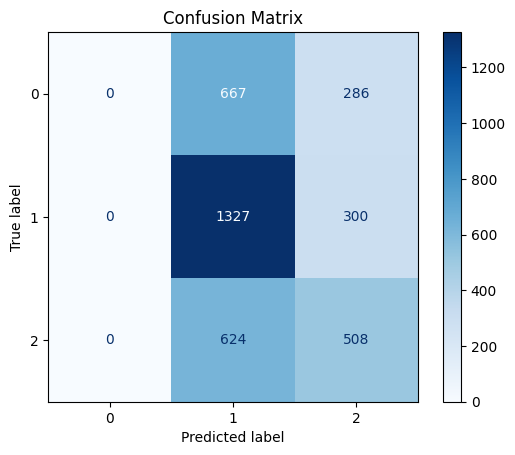

In [338]:
draw_confussion_matrix(y_test, y_pred, cbc.classes_)
#dump(cbc, f'cbc_{test_score}_acc.joblib')